## Importing Libraries

In [32]:
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam

## Data Preprocessing - Final

In [6]:
#define your folder structure
data_dir = "./MusicGenre"
classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [10]:


# Load and preprocess audio data
def load_and_preprocess_data(data_dir, classes, target_shape=(150, 150)):
    data = []
    labels = []

    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print("Processing:", class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                try:
                    audio_data, sample_rate = librosa.load(file_path, sr=None)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue
                
                # Perform Preprocessing
                # Define the duration of each chunk and overlap
                chunk_duration = 4  # seconds
                overlap_duration = 2  # seconds
                
                # Convert duration to sample
                chunk_samples = int(chunk_duration * sample_rate)
                overlap_samples = int(overlap_duration * sample_rate)
                
                # Calculate the number of chunks
                num_chunks = max(1, int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1)
                
                # Iterate over each chunk
                for i in range(num_chunks):
                    # Calculate start and end indices of the chunk
                    start = i * (chunk_samples - overlap_samples)
                    end = start + chunk_samples
                    
                    # Handle edge case where chunk exceeds audio length
                    chunk = audio_data[start:end]
                    if len(chunk) < chunk_samples:
                        # Pad the chunk with zeros if it's shorter than expected
                        chunk = np.pad(chunk, (0, chunk_samples - len(chunk)))
                    
                    # Mel-spectrogram part
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)
                    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
                    
                    # Resize matrix based on provided target shape
                    mel_spectrogram_resized = tf.image.resize(
                        np.expand_dims(mel_spectrogram_db, axis=-1), target_shape
                    ).numpy()
                    
                    # Append data to list
                    data.append(mel_spectrogram_resized)
                    labels.append(i_class)
    
    # Return
    return np.array(data), np.array(labels)


In [11]:
data,labels = load_and_preprocess_data(data_dir,classes)

Processing: blues
Processing: classical
Processing: country
Processing: disco
Processing: hiphop
Processing: jazz


C:\Users\Admin\AppData\Local\Temp\ipykernel_11864\2263362814.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path, sr=None)


Error loading ./MusicGenre\jazz\jazz.00054.wav: 
Processing: metal
Processing: pop
Processing: reggae
Processing: rock


In [12]:
data.shape

(14975, 150, 150, 1)

In [13]:
labels.shape

(14975,)

In [14]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels,num_classes = len(classes)) # Converting labels to one-hot encoding
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [15]:
labels.shape

(14975, 10)

## Splitting of Dataset into Training and Test set

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,test_size=0.2,random_state=42)

# Building Model

In [17]:
model = tf.keras.models.Sequential()

In [18]:
X_train[0].shape

(150, 150, 1)

In [19]:
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=X_train[0].shape))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [21]:
model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [22]:
model.add(Dropout(0.3))

In [23]:
model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [24]:
model.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [25]:
model.add(Dropout(0.3))

In [26]:
model.add(Flatten())

In [27]:
model.add(Dense(units=1200,activation='relu'))

In [28]:
model.add(Dropout(0.45))

In [29]:
#Output layer
model.add(Dense(units=len(classes),activation='softmax'))

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
#Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
#Training Model
training_history = model.fit(X_train,Y_train,epochs=30,batch_size=32,validation_data=(X_test,Y_test))

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 254s 666ms/step - accuracy: 0.1365 - loss: 2.2564 - val_accuracy: 0.3336 - val_loss: 1.8121
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 248s 660ms/step - accuracy: 0.3644 - loss: 1.7200 - val_accuracy: 0.4995 - val_loss: 1.3843
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 254s 677ms/step - accuracy: 0.5041 - loss: 1.3436 - val_accuracy: 0.6391 - val_loss: 1.0262
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 253s 676ms/step - accuracy: 0.6308 - loss: 1.0303 - val_accuracy: 0.7082 - val_loss: 0.8761
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 249s 664ms/step - accuracy: 0.7177 - loss: 0.8005 - val_accuracy: 0.6634 - val_loss: 0.9516
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 252s 673ms/step - accuracy: 0.7723 - loss: 0.6632 - val_accuracy: 0.7776 - val_loss: 0.6495
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 250s 665ms/step - accuracy: 0.8100 - loss: 0.5622 - val_accuracy: 0.8294 - val_loss: 0.5268
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 254s 676ms/step - accuracy: 0.8453 -

In [26]:
model.save("Trained_model.keras") #Mac
model.save("Trained_model.h5") #Windows

/Users/animesh/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
training_history.history

{'loss': [2.0204217433929443,
  1.4848459959030151,
  1.1853015422821045,
  1.003432035446167,
  0.8511081337928772,
  0.7237023711204529,
  0.6284310221672058,
  0.5209404230117798,
  0.45991751551628113,
  0.39179104566574097,
  0.32845956087112427,
  0.29232847690582275,
  0.241055428981781,
  0.2185302972793579,
  0.18324626982212067,
  0.1514931172132492,
  0.16106188297271729,
  0.13241784274578094,
  0.1147485300898552,
  0.12942680716514587,
  0.09043190628290176,
  0.09417214244604111,
  0.08139744400978088,
  0.08271943777799606,
  0.07774775475263596,
  0.08096491545438766,
  0.07381734251976013,
  0.07115212827920914,
  0.05207819119095802,
  0.09434403479099274],
 'accuracy': [0.2620200216770172,
  0.4784640967845917,
  0.5987479090690613,
  0.655592679977417,
  0.7103505730628967,
  0.7560935020446777,
  0.7890651226043701,
  0.8274624347686768,
  0.842570960521698,
  0.868781328201294,
  0.8880634307861328,
  0.9029215574264526,
  0.9199498891830444,
  0.9271285533905029

In [29]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

In [21]:
X_train

array([[[[3.62469602e+00],
         [1.06304932e+00],
         [5.78081071e-01],
         ...,
         [7.72284317e+01],
         [4.75934067e+01],
         [1.37238359e+01]],

        [[6.16288261e+01],
         [1.11565666e+02],
         [1.24939728e+02],
         ...,
         [2.26902710e+02],
         [1.67433502e+02],
         [9.14233856e+01]],

        [[9.65764847e+01],
         [1.58142334e+02],
         [1.55722260e+02],
         ...,
         [2.27748688e+02],
         [3.04347015e+02],
         [1.79836197e+02]],

        ...,

        [[5.75669517e-04],
         [1.67717793e-04],
         [4.96678513e-05],
         ...,
         [8.38105916e-05],
         [8.60303917e-05],
         [1.59282630e-04]],

        [[5.21527836e-04],
         [1.09017732e-04],
         [2.23153370e-06],
         ...,
         [8.25764164e-06],
         [1.78673235e-05],
         [1.52539389e-04]],

        [[5.25240088e-04],
         [1.06741449e-04],
         [1.71574825e-07],
         ...,
 

In [15]:
#Reloading model variable
model = tf.keras.models.load_model("Trained_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 74, 74, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                   

In [16]:
#Reloading Training history
import json
with open("training_hist.json",'r') as json_file:
    training_history_data = json.load(json_file)

In [17]:
training_history_data.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Model Evaluation - I

In [26]:
#Model evaluation on Training set
train_loss,train_accuracy = model.evaluate(X_train,Y_train)

  1/375 [..............................] - ETA: 1:32 - loss: 0.0472 - accuracy: 0.9688

2024-09-05 13:06:22.984408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 16s 42ms/step - loss: 0.0432 - accuracy: 0.9856


In [28]:
train_loss,train_accuracy

(0.04322619363665581, 0.9856427311897278)

In [27]:
#Model evaluation on Validation set
val_loss,val_accuracy = model.evaluate(X_test,Y_test)

94/94 [==============================] - 4s 43ms/step - loss: 0.4700 - accuracy: 0.8925


In [29]:
val_loss,val_accuracy

(0.4700189232826233, 0.8924874663352966)

In [37]:
training_history_data['val_loss']

[1.7277613878250122,
 1.2436965703964233,
 1.0371183156967163,
 0.8820503354072571,
 0.7604389190673828,
 0.7003780603408813,
 0.622701108455658,
 0.6098797917366028,
 0.573236346244812,
 0.5700345039367676,
 0.45887571573257446,
 0.43867433071136475,
 0.4503192901611328,
 0.4671923816204071,
 0.5040718913078308,
 0.5031691193580627,
 0.4341115951538086,
 0.4256725609302521,
 0.39570438861846924,
 0.4640021324157715,
 0.4466232657432556,
 0.5173290371894836,
 0.37244242429733276,
 0.4412586987018585,
 0.4068472683429718,
 0.5015928149223328,
 0.44153183698654175,
 0.5383853912353516,
 0.518845796585083,
 0.4700189232826233]

## Accuracy and Loss Visualization

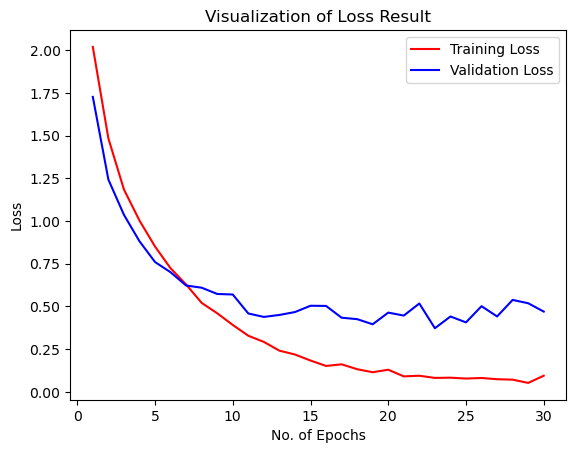

In [43]:
#Visualization of Loss
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history_data['loss'],label="Training Loss",color='red')
plt.plot(epochs,training_history_data['val_loss'],label="Validation Loss",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

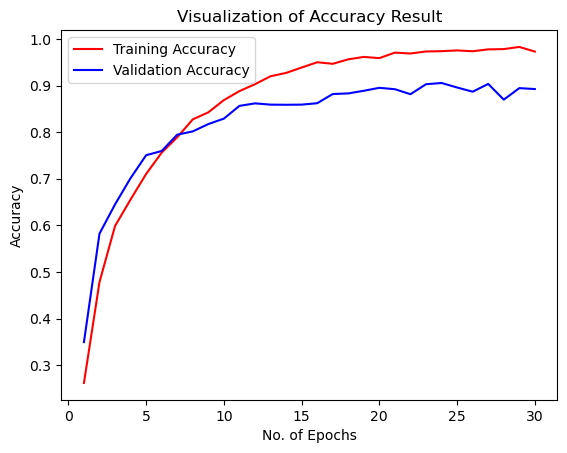

In [46]:
#Visualization of Accuracy
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history_data['accuracy'],label="Training Accuracy",color='red')
plt.plot(epochs,training_history_data['val_accuracy'],label="Validation Accuracy",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

## Precision,Recall,Confusion Matrix - Model Evaluation-II

In [19]:
X_test.shape

(2995, 150, 150, 1)

In [20]:
y_pred = model.predict(X_test)
y_pred

 3/94 [..............................] - ETA: 2s 

2024-09-15 20:19:57.496858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 4s 41ms/step


array([[2.6562146e-04, 2.8876246e-12, 9.4110817e-01, ..., 5.3116322e-02,
        1.0774442e-06, 5.5056820e-03],
       [1.2050692e-08, 1.7227166e-14, 1.1675338e-05, ..., 7.2019488e-09,
        4.7832871e-09, 9.8800910e-01],
       [1.1936303e-06, 1.2878280e-05, 3.1493261e-04, ..., 2.3610676e-06,
        1.9415455e-07, 4.0005866e-04],
       ...,
       [9.9997008e-01, 3.0055109e-18, 2.9890662e-05, ..., 2.7753857e-13,
        4.3859512e-13, 3.1008829e-09],
       [6.4050123e-06, 9.9941623e-01, 5.5354085e-05, ..., 4.0306262e-05,
        4.0627659e-05, 4.9173774e-05],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.5828971e-22,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [21]:
y_pred.shape

(2995, 10)

In [22]:
predicted_categories = np.argmax(y_pred,axis=1)
predicted_categories

array([2, 9, 6, ..., 0, 1, 4])

In [24]:
Y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
Y_test.shape

(2995, 10)

In [27]:
true_categories = np.argmax(Y_test,axis=1)
true_categories

array([7, 6, 6, ..., 0, 1, 4])

In [28]:
classes

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [29]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(true_categories,predicted_categories)
# Precision Recall F1score
print(classification_report(true_categories,predicted_categories,target_names=classes))

              precision    recall  f1-score   support

       blues       0.95      0.79      0.86       302
   classical       0.91      0.97      0.94       298
     country       0.79      0.87      0.83       317
       disco       0.93      0.92      0.92       312
      hiphop       0.97      0.91      0.94       277
        jazz       0.96      0.82      0.88       311
       metal       0.95      0.94      0.95       302
         pop       0.85      0.94      0.89       289
      reggae       0.93      0.87      0.90       296
        rock       0.75      0.90      0.82       291

    accuracy                           0.89      2995
   macro avg       0.90      0.89      0.89      2995
weighted avg       0.90      0.89      0.89      2995



## Confusion Matrix Visualization

In [31]:
cm

array([[238,   3,  27,   2,   0,   0,   1,   6,   3,  22],
       [  0, 289,   1,   1,   0,   5,   0,   1,   0,   1],
       [  4,   2, 277,   4,   0,   5,   2,   3,   5,  15],
       [  1,   0,   1, 287,   0,   0,   0,   8,   4,  11],
       [  0,   0,   0,   0, 252,   0,   3,  15,   3,   4],
       [  6,  19,  19,   1,   0, 255,   0,   2,   1,   8],
       [  0,   0,   0,   0,   2,   0, 285,   1,   0,  14],
       [  0,   2,   4,   1,   4,   1,   0, 271,   2,   4],
       [  1,   1,  15,   9,   1,   0,   0,   5, 257,   7],
       [  0,   0,   8,   5,   0,   1,   8,   6,   1, 262]])

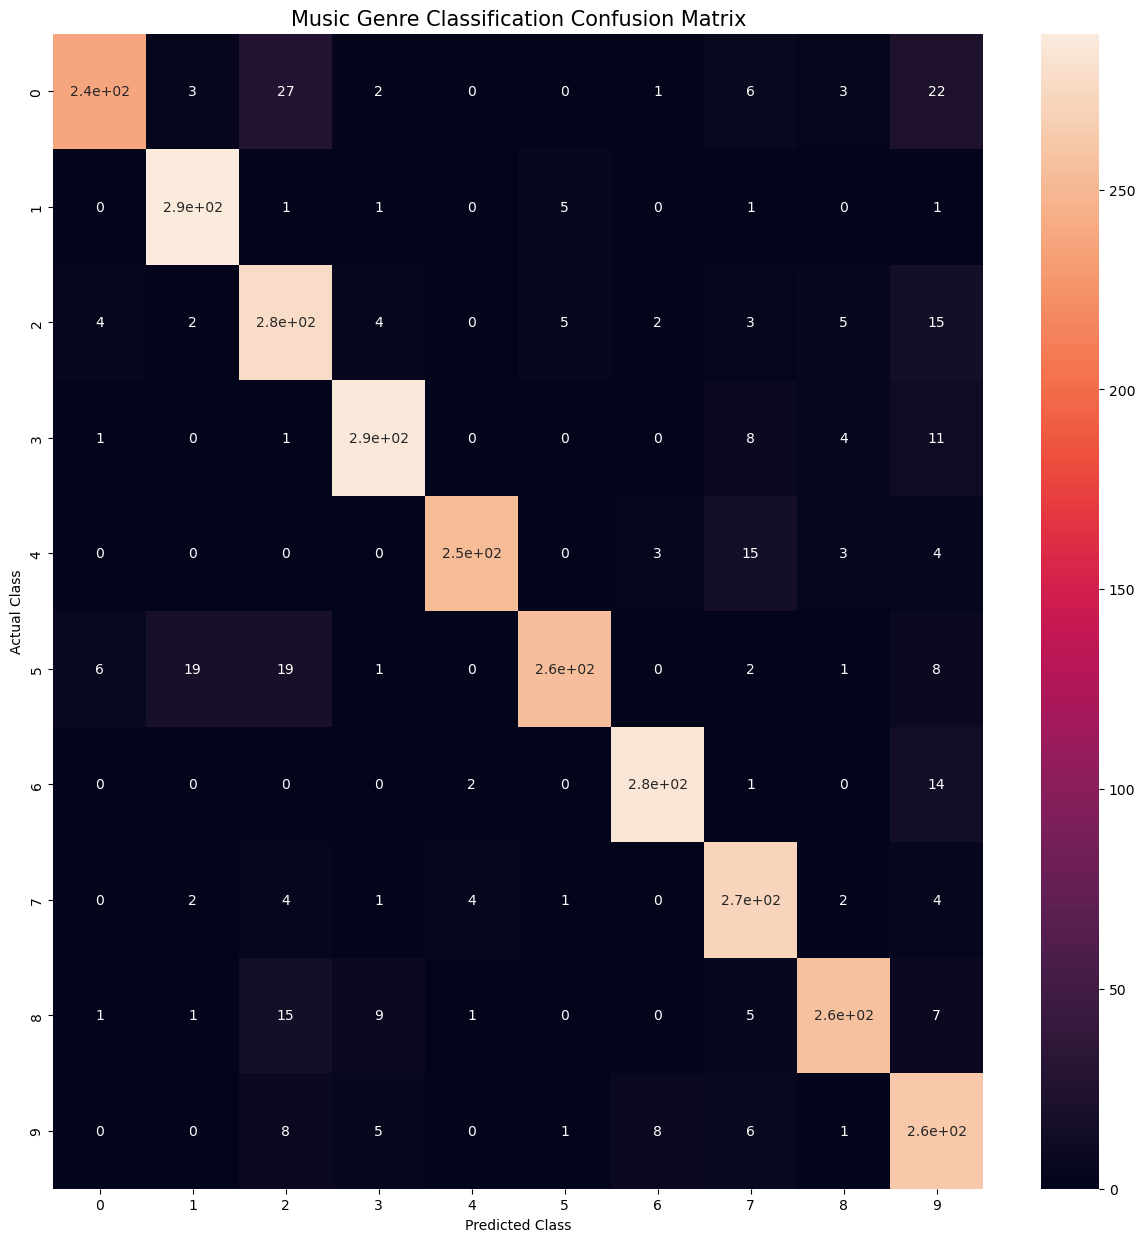

In [39]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(cm,annot=True,annot_kws={"size":10})
plt.xlabel("Predicted Class",fontsize=10)
plt.ylabel("Actual Class",fontsize=10)
plt.title("Music Genre Classification Confusion Matrix",fontsize=15)
plt.show()